In [1]:
import os
import cv2
import random
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go



from collections import Counter

# Step 1: Loading Dataset

In [2]:
# Dataset Source: Kaggle
# Link: https://www.kaggle.com/datasets/jessicali9530/lfw-dataset/data

In [3]:
def Load_Dataset(base_path="lfw-deepfunneled-50class", image_size=(160, 160)):
    images = []
    labels = []
    target_names = []
    label_map = {}
    
    # Loop through each person's folder
    for person_name in os.listdir(base_path):
        person_dir = os.path.join(base_path, person_name)
        if os.path.isdir(person_dir):
            if person_name not in label_map:
                label_map[person_name] = len(label_map)
                target_names.append(person_name)
            for image_file in os.listdir(person_dir):
                image_path = os.path.join(person_dir, image_file)
                img = cv2.imread(image_path)
                if img is not None:
                    # Resize to a uniform size (e.g., 160x160 for FaceNet)
                    img = cv2.resize(img, image_size)
                    images.append(img)
                    labels.append(label_map[person_name])
                    
                    
    # Print Dataset Overview
    print("Number of people:", len(target_names))
    print("Number of images:", len(images))
    print("Number of labels:", len(labels))
    print("Image shape:", images[0].shape)  
    
    return np.array(images), np.array(labels), target_names

# Load the dataset
images, labels, target_names = Load_Dataset()


Number of people: 50
Number of images: 80
Number of labels: 80
Image shape: (160, 160, 3)


# Step 2: Overview of Dataset

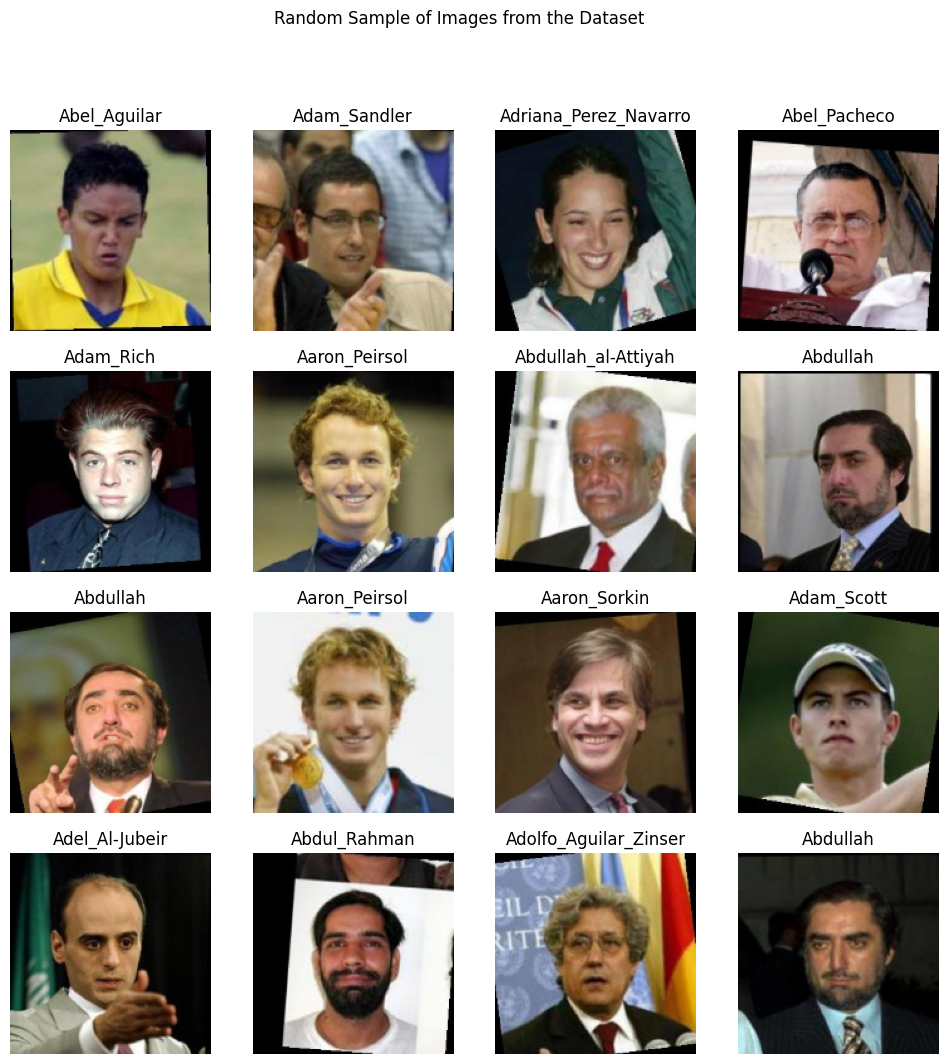

In [4]:
num_samples = 16  # Number of samples to display
sample_indices = random.sample(range(len(images)), num_samples)

plt.figure(figsize=(12, 12))
for i, idx in enumerate(sample_indices):
    plt.subplot(4, 4, i + 1)
    # Convert image from BGR to RGB for proper display in matplotlib
    plt.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))
    plt.title(target_names[labels[idx]])
    plt.axis("off")
plt.suptitle("Random Sample of Images from the Dataset")
plt.show()


# Step 3: EDA - Image Analysis

## Step 3)i): EDA - Class Distribution Analysis

In [5]:
# Count images per label
label_counts = Counter(labels)

# Build a mapping from class name to image count
class_counts = {target_names[i]: label_counts[i] for i in range(len(target_names))}

# Select 20 random classes (or fewer if not enough classes)
selected_keys = random.sample(list(class_counts.keys()), k=min(20, len(class_counts)))
selected_counts = [class_counts[key] for key in selected_keys]

# Create a horizontal bar plot using Plotly
fig = px.bar(
    x=selected_counts,
    y=selected_keys,
    orientation='h',
    labels={'x': 'Number of Images', 'y': 'Person'},
    title='Distribution of Images per Person (20 Random Classes)'
)
fig.show()


In [6]:
# Count images per label
label_counts = Counter(labels)

# Build a mapping from class name to image count
class_counts = {target_names[i]: label_counts[i] for i in range(len(target_names))}

# Select random classes 
selected_keys = random.sample(list(class_counts.keys()), k=min(20, len(class_counts)))
selected_counts = [class_counts[key] for key in selected_keys]

# Create a bubble plot 
fig = px.scatter(
    x=selected_keys,
    y=selected_counts,
    size=selected_counts,
    color=selected_counts,  
    color_continuous_scale='Viridis',  
    labels={'x': 'Person', 'y': 'Number of Images'},
    title='Bubble Plot of Images per Person (20 Random Classes) with Color Scheme'
)

# The 'sizeref' parameter scales the bubble sizes appropriately.
fig.update_traces(mode='markers', marker=dict(
    sizemode='area',
    sizeref=2.*max(selected_counts)/(40.**2),
    line_width=2
))

fig.show()


## Step 3)ii): EDA - Image Dimension and Format Verification

- Verify that all images have been resized uniformly

In [7]:
# Check the unique shapes of all images
unique_shapes = {img.shape for img in images}
print("Unique image shapes in the dataset:", unique_shapes)

# You should expect each image to have the shape (160, 160, 3).


Unique image shapes in the dataset: {(160, 160, 3)}


## Step 3)iii): EDA - Pixel Intensity and Color Channel Analysis

- Calculate overall pixel statistics such as mean, median, and standard deviation for each color channel. Also plot histograms to observe the intensity distribution, which helps decide if further normalization is needed

In [8]:
# Combine pixel data from all images
all_pixels = np.concatenate([img.reshape(-1, 3) for img in images], axis=0)

# Calculate statistical metrics
mean = np.mean(all_pixels, axis=0)
median = np.median(all_pixels, axis=0)
std = np.std(all_pixels, axis=0)

print("Overall pixel intensity stats for each channel (B, G, R):")
print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std)

# Create a figure with histograms for each channel
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=all_pixels[:, 0],
    nbinsx=50,
    marker_color='blue',
    opacity=0.5,
    name='Blue channel'
))
fig.add_trace(go.Histogram(
    x=all_pixels[:, 1],
    nbinsx=50,
    marker_color='green',
    opacity=0.5,
    name='Green channel'
))
fig.add_trace(go.Histogram(
    x=all_pixels[:, 2],
    nbinsx=50,
    marker_color='red',
    opacity=0.5,
    name='Red channel'
))

# Set the layout for overlapping histograms
fig.update_layout(
    barmode='overlay',
    title="Pixel Intensity Distribution",
    xaxis_title="Pixel Intensity",
    yaxis_title="Frequency"
)

fig.show()


Overall pixel intensity stats for each channel (B, G, R):
Mean: [ 78.68214209  91.0687627  104.27067773]
Median: [ 62.  80. 101.]
Standard Deviation: [68.06385628 70.90312506 75.91449681]


## Step 3)iv): EDA - Quality and Noise Assessment

- Compute a blurriness score using the variance of the Laplacian.

In [9]:
def variance_of_laplacian(image):
    """Compute the Laplacian of the image and return its variance."""
    return cv2.Laplacian(image, cv2.CV_64F).var()

# Compute blurriness scores for each image (convert to grayscale first)
blurriness_scores = [
    variance_of_laplacian(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    for img in images
]

# Print statistical summary
print("Blurriness score summary:")
print("Mean:", np.mean(blurriness_scores))
print("Standard Deviation:", np.std(blurriness_scores))

# Create a histogram of blurriness scores using Plotly
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=blurriness_scores,
    nbinsx=50,
    marker_color='purple',
    opacity=0.7,
    name='Blurriness Scores'
))

fig.update_layout(
    title="Distribution of Blurriness Scores",
    xaxis_title="Blurriness Score",
    yaxis_title="Frequency"
)

fig.show()


Blurriness score summary:
Mean: 600.8263643377495
Standard Deviation: 368.97997675968617


In [10]:
# Define the base path used in Load_Dataset
base_path = "lfw-deepfunneled-50class"  # Adjust this path if needed

file_names = []
file_sizes = []

# Iterate through each person's folder to capture file metadata.
for person_name in os.listdir(base_path):
    person_dir = os.path.join(base_path, person_name)
    if os.path.isdir(person_dir):
        for image_file in os.listdir(person_dir):
            image_path = os.path.join(person_dir, image_file)
            file_names.append(image_file)
            file_sizes.append(os.path.getsize(image_path))

# Display a few examples of file names and their sizes.
print("Sample file names and sizes:")
for name, size in zip(file_names[:5], file_sizes[:5]):
    print(f"{name}: {size} bytes")


Sample file names and sizes:
Aaron_Eckhart_0001.jpg: 6855 bytes
Aaron_Guiel_0001.jpg: 9631 bytes
Aaron_Patterson_0001.jpg: 7556 bytes
Aaron_Peirsol_0001.jpg: 7877 bytes
Aaron_Peirsol_0002.jpg: 9700 bytes
